# Práctica 2: Planificación de trayectorias
En la práctica 1 realizamos la estimación de las variables de articulación para un robot de tipo RR utilizando el problema cinemático directo y el problema cinemático inverso. Gracias a ello, pudimos simular el movimiento de un robot a lo largo de una trayectoria rectilínea con velocidad constante, y observar las diferentes indeterminaciones que existían. 

En el mundo real, las trayectorias son más complejas que una línea a velocidad constante. Normalmente se requiere tener en cuenta que comenzamos a velocidad 0 y debemos acabar a la misma velocidad 0, y que la trayectoria no va a ser totalmente recta, puesto que muchas veces tenemos que sortear obstáculos. Para ello podemos usar una trayectoria de tipo 4-3-4. 

En esta práctica realizaremos un planificador de trayectorias de tipo 4-3-4, en las que las velocidades y aceleraciones inicial y final son nulas. Hemos estudiado este tipo de trayectorias en teoría, pero recordaremos que constan de tres fases y que interpolan los puntos de inicio, despegue, asentamiento y fin, que nombramos como $\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$. 

Para ello: 
1. Usaremos las funciones `pcd` y `pci` de la práctica anterior, para poder calcular los parámetros del robot.
2. Definiremos la función `planif`, que tomará como entrada estos puntos, el tiempo de duración de cada uno de los trayectos y el periodo de muestreo (para la representación de la trayectoria). Esta función nos devolverá un array con los coeficientes de las ecuaciones de cada una de las trayectorias. 
3. Evaluaremos $\theta_1(t)$ y $\theta_2(t)$ en cada instante usando dichos coeficientes, y mostraremos el robot utilizando la función `robot`y las animaciones que usamos en la práctica anterior. 
4. Mostraremos también gráficas con el progreso de las variables $\theta_i$, la velocidad y la aceleración del robot en cada instante de tiempo. 

En primer lugar, definiremos las posiciones de los puntos de inicio, despegue, asentamiento y fin ($\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$).

In [1]:
import numpy as np
pini = np.array([1, 0])
pdes = np.array([1, 0.1])
pase = np.array([1.5, 0.1])
pfin = np.array([1.5, 0])
t1, t2, tn = 1, 1, 1
L1, L2 = 1, 1
T = 0.01

### Trayectoria 4-3-4
Como hemos visto en el tema 4, las trayectorias del tipo 4-3-4 siguen unas ecuaciones predefinidas. Para empezar, asumimos que: 
- En el punto de inicio, la aceleración y velocidad son nulas.
- En el punto final la velocidad y aceleración son nulas. 
- En los puntos intermedios debe haber continuidad en posición, velocidad y aceleración. 

A lo largo de la práctica utilizaremos el tiempo normalizado: 

$$ t = \frac{\tau-\tau_{i-1}}{\tau_{i}-\tau_{i-1}} = \frac{\tau-\tau_{i-1}}{t_i} $$

donde $\tau$ es el tiempo real en segundos, $\tau_i$ es el tiempo real al final del $i$-esimo intervalo y $t_i$ es el tiempo total requerido en dicho intervalo. 


Para hacer el desplazamiento con un solo segmento, necesitaríamos un polinomio de grado 8, difícil de resolver y que puede conducir a movimientos extraños y bruscos. Para evitarlo, dividimos la trayectoria en tres segmentos ($h_1$, $h_2$ y $h_n$) con polinomios de grado 4, 3 y 4. Los polinomios que definen el movimiento en cada segmento son:

$$ h_1(t) = a_{14}t^4 + a_{13}t^3 + a_{12}t^2 + a_{11}t + a_{10} $$
$$ h_2(t) = a_{23}t^3 + a_{22}t^2 + a_{21}t + a_{20} $$
$$ h_n(t) = a_{n4}t^4 + a_{n3}t^3 + a_{n2}t^2 + a_{n1}t + a_{n0} $$

Para determinar el movimiento debemos calcular el valor de los 14 coeficientes $a_{ij}$ definidos en los polinomios anteriores. Como hemos visto en clase de teoría, 7 de ellos se pueden calcular directamente a partir de alguna de las restricciones que hemos asumido (velocidad y aceleración iniciales nulas, etc.). Los 7 restantes se pueden calcular a partir de un sistema de 7 ecuaciones con 7 incognitas (véanse las diapositivas 34 y 35 del tema 4) que se puede resolver matricialmente:

$$ \mathbf{x} = \mathbf{C}^{-1}\mathbf{y}$$

siendo:

$$ C = \begin{pmatrix}
1 & 1 & 0 & 0 & 0 & 0 & 0 \\
\frac{3}{t_1} & \frac{4}{t_1} & -\frac{1}{t_2} & 0 & 0 & 0 & 0 \\
\frac{6}{t_1^2} & \frac{12}{t_1^2} & 0 & -\frac{2}{t_2^2} & 0 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 0 & 0 \\
0 & 0 & \frac{1}{t_2} & \frac{2}{t_2} & \frac{3}{t_2} & -\frac{3}{t_n} & \frac{4}{t_n} \\
0 & 0 & 0 & \frac{2}{t_2^2} & \frac{6}{t_2^2} & \frac{6}{t_n^2} & -\frac{12}{t_n^2} \\
0 & 0 & 0 & 0 & 0 & 1 & -1 
\end{pmatrix}  $$

$$ \mathbf{y} = (\delta_1 - \frac{a_0t_1^2}{2}-v_0t_1, -a_0t1-v_0, -a_0, \delta_2, -a_ft_n + v_f, a_f, \delta_n + \frac{a_ft_n^2}{2}-v_ft_n)$$

por lo que $\mathbf{x}$ tendría la siguiente forma:

$$ \mathbf{x} = (a_{13}, a_{14}, a_{21}, a_{22}, a_{23}, a_{n3}, a_{n4})$$


En la definición de $\mathbf{y}$, los valores $a$ y $v$ representan la aceleración y la velocidad en los puntos inicial y final (no deben confundirse con los coeficientes $a_{ij}$), mientras que $\delta_i$ se define como la diferencia entre $h_i$ al principio y al final del iésimo segmento.


En resumen: 
1. Para obtener los valores de $\theta_1$ y $\theta_2$ tenemos que evaluar los polinomios $h_1$, $h_2$ y $h_n$ (definimos los tres polinomios para **cada** articulación) en el tiempo. 
2. Para calcular $h_1$, $h_2$ y $h_n$, debemos obtener todos los coeficientes $a_{ij}$. 
3. Para calcular los coeficientes $a_{ij}$ necesistamos conocer los valores de $\theta_i$, $a$ (aceleración) y $v$ (velocidad) al principio y al final de cada segmento de la trayectoria.
4. Para calcular los $\theta_i$ en los puntos de inicio, despegue, asentamiento y fin (principio y fin de cada segmento de la trayectoria) haremos uso del `pci` de la práctica anterior. 


In [2]:
def pci(L1, L2, x, y):
    th2 = np.arccos((x * x + y * y - L1 * L1 - L2 * L2)/(2 * L1 * L2))
    sinTh2 = np.sin(th2)
    cosTh2 = np.cos(th2)
    th1 = np.arctan2((y * (L1 + L2 * cosTh2) - (x * L2 * sinTh2)), (x * (L1 + L2 * cosTh2) + (y * L2 * sinTh2)))
    sinTh2 = np.sin(-th2)
    cosTh2 = np.cos(-th2)
    th1_neg = np.arctan2((y * (L1 + L2 * cosTh2) - (x * L2 * sinTh2)), (x * (L1 + L2 * cosTh2) + (y * L2 * sinTh2)))
    if th1 >= 0:
        return np.r_['0,2', th1, th2]
    else:
        return np.r_['0,2', th1_neg, -th2]

### Cálculo de la trayectoria

Para calcular los coeficientes $a_{ij}$ que definen las ecuaciones de la trayectoria vamos a usar una función, `planif`, que reciba como entrada el valor $\theta_i$ en cada punto de la trayectoria ($\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$), y devuelva como salida los coeficientes  $a_{ij}$. Es recomendable devolver los coeficientes como un array 2D, donde cada fila contiene los coeficientes de una ecuación (3 filas), y los coeficientes están ordenados de menor exponente a mayor (5 columnas).


Dado que nuestro robot tiene 2 articulaciones, habrá que llamar 2 veces a `planif`, una con los $\theta_i$ de cada articulación. 

In [3]:
def planif(thini, thdes, thase, thfin, t1, t2, tn):
    # Punto Inicial
    theta0 = thini[0]
    v0 = 0
    a0 = 0
    # Punto Despegue
    theta1 = thdes[0]
    # Punto Asentamiento
    theta2 = thase[0]
    # Punto Final
    thetaf = thfin[0]
    vf = 0
    af = 0
    # Primer Segmento
    a10 = theta0
    a11 = v0 * t1
    a12 = (a0 * t1 * t1)/2
    # Segundo Segmento
    a20 = theta1
    # Tercer Segmento
    an0 = thetaf
    an1 = vf * tn
    an2 = (af * tn * tn)/2
    # Cambios de las variables de articulación entre segmentos contiguos
    delta1 = theta1 - theta0
    delta2 = theta2 - theta1
    deltan = thetaf - theta2
    # y = Cx
    y = np.matrix([[delta1 - (a0 * t1 * t1)/2 - v0 * t1], 
                   [-a0 * t1 - v0], 
                   [-a0],
                   [delta2], 
                   [-af * tn + vf], 
                   [af], 
                   [deltan + (af * tn * tn)/2 - vf * tn]])
    
    C = np.matrix([[1, 1, 0, 0, 0, 0, 0], 
                   [3/t1, 4/t1, -1/t2, 0, 0, 0, 0], 
                   [6/(t1 * t1), 12/(t1 * t1), 0, -2/(t2 * t2), 0, 0, 0], 
                   [0, 0, 1, 1, 1, 0, 0],
                   [0, 0, 1/t2, 2/t2, 3/t2, -3/tn, 4/tn],
                   [0, 0, 0, 2/(t2 * t2), 6/(t2 * t2), 6/(tn * tn), -12/(tn * tn)],
                   [0, 0, 0, 0, 0, 1, -1]])
    # x = (C^-1)*y = Transpuesta(a13, a14, a21, a22, a23, an3, an4)
    x = np.linalg.inv(C) * y
    
    # matriz coef = (a10, a11, a12, a13, a14)
    #               (a20, a21, a22, a23, 0)
    #               (an0, an1, an2, an3, an4)
    
    return np.matrix([[a10, a11, a12, x[0,0], x[1,0]],
                      [a20, x[2,0], x[3,0], x[4,0], 0],
                      [an0, an1, an2, x[5,0], x[6,0]]])

thini = pci(L1, L2, pini[0], pini[1])
thdes = pci(L1, L2, pdes[0], pdes[1])
thase = pci(L1, L2, pase[0], pase[1])
thfin = pci(L1, L2, pfin[0], pfin[1])

coef1 = planif(thini[0], thdes[0], thase[0], thfin[0], t1, t2, tn)
coef2 = planif(thini[1], thdes[1], thase[1], thfin[1], t1, t2, tn)

A continuación vamos a simular el desplazamiento. Para ello necesitamos muestrear el tiempo con periodo de muestreo $T$ y, en cada instante de tiempo, obtener el valor de las variables de articulación ($\theta_1$ y $\theta_2$). Esto debemos hacerlo independientemente para cada segmento de la trayectoria, usando las ecuaciones que hemos calculado anteriormente.

Recordad que estamos utilizando el tiempo normalizado: 

$$ t = \frac{\tau-\tau_{i-1}}{\tau_i -\tau_{i-1}}$$

con $\tau$ el tiempo en segundos, $\tau_i$ el tiempo al final del $i$-ésimo segmento de la trayectoria y $\tau_i-\tau_{i-1}$ el tiempo que toma en el iésimo segmento de la trayectoria. Asimismo, recuerda que en el último segmento realizamos un último cambio de variable $\hat{t}=t-1$, con lo que el rango de tiempo normalizado pasa de (0,1) a (-1,0). 

In [4]:
from numpy.polynomial.polynomial import polyval

# Ecuaciones de la Trayectoria
# a1 = [a14, a13, a12, a11, a10]
# a2 = [a23, a22, a21, a20]
# an = [an4, an3, an2, an1, an0]

a1_coef1 = [coef1[0,4], coef1[0,3], coef1[0,2], coef1[0,1], coef1[0,0]]
a2_coef1 = [coef1[1,3], coef1[1,2], coef1[1,1], coef1[1,0]]
an_coef1 = [coef1[2,4], coef1[2,3], coef1[2,2], coef1[2,1], coef1[2,0]]

a1_coef2 = [coef2[0,4], coef2[0,3], coef2[0,2], coef2[0,1], coef2[0,0]]
a2_coef2 = [coef2[1,3], coef2[1,2], coef2[1,1], coef2[1,0]]
an_coef2 = [coef2[2,4], coef2[2,3], coef2[2,2], coef2[2,1], coef2[2,0]]

eval1_coef1 = np.polyval(a1_coef1, np.arange(0, 1, T))
eval2_coef1 = np.polyval(a2_coef1, np.arange(0, 1, T))
evaln_coef1 = np.polyval(an_coef1, np.arange(0, 1, T)-1)

eval1_coef2 = np.polyval(a1_coef2, np.arange(0, 1, T))
eval2_coef2 = np.polyval(a2_coef2, np.arange(0, 1, T))
evaln_coef2 = np.polyval(an_coef2, np.arange(0, 1, T)-1)

eval1 = np.r_[eval1_coef1, eval2_coef1, evaln_coef1]
eval2 = np.r_[eval1_coef2, eval2_coef2, evaln_coef2]

## Trazado de la Trayectoria
A continuación vamos a representar el movimiento del robot y los diferentes puntos de la trayectoria. Usaremos `matplotlib.pyplot` para visualización y las herramientas que ya utilizamos en la práctica anterior. Tened en cuenta que vamos a dibujar la trayectoria del efector a partir de los ángulos de cada articulación, esto es, necesitamos resolver el PCD.

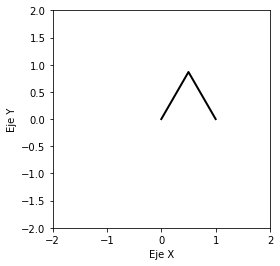

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

def pcd(L1, L2, th1, th2):
    px = L1 * np.cos(th1) + L2 * np.cos(th1 + th2)
    py = L1 * np.sin(th1) + L2 * np.sin(th1 + th2)
    return np.c_[px, py]

def robot(L1, th1, p, ax):
    x = [0, L1 * np.cos(th1), p[0]]
    y = [0, L1 * np.sin(th1), p[1]]
    ax.plot(x, y, color = 'k', linewidth = 2)
    ax.axis([-2, 2, -2, 2])
    ax.set_aspect('equal')
    
def init(ax):
    ax.clear()
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    
def pintarPCD(i, L1, L2, th1, th2, ax):
    init(ax)
    p = pcd(L1, L2, th1, th2)
    ax.plot(p[:i,0], p[:i,1])
    robot(L1, th1[i], p[i], ax)

fig, ax = plt.subplots()
N = eval1.shape[0]
anim = animation.FuncAnimation(fig, pintarPCD, frames = N, fargs = (L1, L2, eval1, eval2, ax), interval = .1/T)
HTML(anim.to_jshtml())

## Visualización de las variables
Ahora mostraremos, en función del tiempo: 
1. Los valores de $\theta_1$ y $\theta_2$
2. Los valores de velocidad $v_1$ y $v_2$
3. Los valores de aceleración $a_1$ y $a_2$

Dado que la velocidad y la acelaración son la primera y la segunda derivada de la trayectoria, podemos utilizar `polyder` para obtener sus coeficientes de los polinomios que definen la velocidad y la aceleración y, una vez obtenidos, `polyval` para evaluar las funciones resultantes.


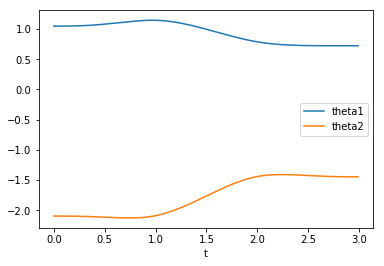

In [6]:
t = np.arange(0, t1 + t2 + tn, T)
plt.plot(t, eval1, label= "theta1")
plt.plot(t, eval2, label= "theta2")
plt.xlabel("t")
plt.legend(loc = 5)

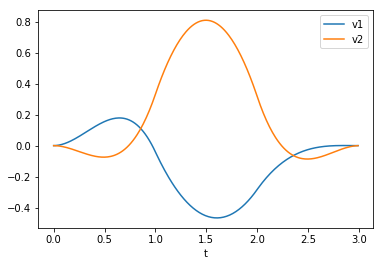

In [7]:
from numpy.polynomial.polynomial import polyder

h1_coef1 = np.polyval(np.polyder(a1_coef1), np.arange(0, 1, T))
h2_coef1 = np.polyval(np.polyder(a2_coef1), np.arange(0, 1, T))
hn_coef1 = np.polyval(np.polyder(an_coef1), np.arange(0, 1, T)-1)

h1_coef2 = np.polyval(np.polyder(a1_coef2), np.arange(0,1,T))
h2_coef2 = np.polyval(np.polyder(a2_coef2), np.arange(0,1,T))
hn_coef2 = np.polyval(np.polyder(an_coef2), np.arange(0,1,T)-1)

v1 = np.r_[h1_coef1, h2_coef1, hn_coef1]
v2 = np.r_[h1_coef2, h2_coef2, hn_coef2]

plt.plot(t, v1, label = "v1")
plt.plot(t, v2, label = "v2")
plt.xlabel("t")
plt.legend(loc = 1)

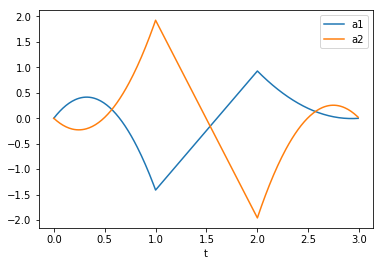

In [8]:
h1_coef1 = np.polyval(np.polyder(a1_coef1, m = 2), np.arange(0, 1, T))
h2_coef1 = np.polyval(np.polyder(a2_coef1, m = 2), np.arange(0, 1, T))
hn_coef1 = np.polyval(np.polyder(an_coef1, m = 2), np.arange(0, 1, T)-1)

h1_coef2 = np.polyval(np.polyder(a1_coef2, m = 2), np.arange(0, 1, T))
h2_coef2 = np.polyval(np.polyder(a2_coef2, m = 2), np.arange(0, 1, T))
hn_coef2 = np.polyval(np.polyder(an_coef2, m = 2), np.arange(0, 1, T)-1)

a1 = np.r_[h1_coef1, h2_coef1, hn_coef1]
a2 = np.r_[h1_coef2, h2_coef2, hn_coef2]

plt.plot(t, a1, label = "a1")
plt.plot(t, a2, label = "a2")
plt.xlabel("t")
plt.legend(loc = 1)